# Stroke_Prediction_18: PODSTAWOWY MODEL KLASYFIKACJI PYTORCH PRZEZ OSADZANIE

In [1]:
import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())

Mon Aug 24 15:52:51 2020


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Odpalam karte graficzną GPU (której nie mam)

In [3]:
device = torch.device('cpu') # obliczenia robie na CPU
#device = torch.device('cuda') # obliczenia robie na GPU

### Importuję dane 

In [4]:
import pandas as pd

df = pd.read_csv('/home/wojciech/Pulpit/1/Stroke_Prediction_CLEAR.csv')
df.head(3)

,Unnamed: 0,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10
0,1,30650,Male,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,58.093151,"(53.126, 59.076]"
1,3,57008,Female,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,70.076712,"(65.121, 74.11]"
2,6,53725,Female,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0,52.041096,"(48.082, 53.126]"


In [5]:
df.shape

(29062, 14)

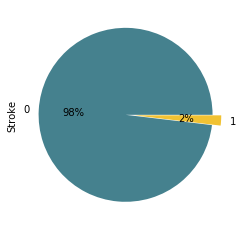

In [6]:
df.Stroke.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['#45818e', '#f1c232'], explode=(0.05, 0.05))

### Uporządkowanie kolumn z danymi kategorycznymi i danymi ciągłymi

In [7]:
df.columns

Index(['Unnamed: 0', 'ID', 'Gender', 'Hypertension', 'Heart_Disease',
       'Ever_Married', 'Type_Of_Work', 'Residence', 'Avg_Glucose', 'BMI',
       'Smoking_Status', 'Stroke', 'Age_years', 'Age_years_10'],
      dtype='object')

In [8]:
df.Type_Of_Work

0              Private
1              Private
2              Private
3        Self-employed
4              Private
             ...      
29057         children
29058         Govt_job
29059          Private
29060          Private
29061          Private
Name: Type_Of_Work, Length: 29062, dtype: object

In [9]:
categorical_columns = ['Gender','Hypertension', 'Heart_Disease','Ever_Married','Type_Of_Work','Residence','Smoking_Status','Age_years_10']
numerical_columns = ['Avg_Glucose', 'BMI', 'Age_years']

### Ustalamy, że zmienną wynikową jest kolumna 'Stroke'

In [10]:
outputs = ['Stroke']

### Cyfryzacja zmiennych tekstowych

In [11]:
df.dtypes

Unnamed: 0          int64
ID                  int64
Gender             object
Hypertension        int64
Heart_Disease       int64
Ever_Married       object
Type_Of_Work       object
Residence          object
Avg_Glucose       float64
BMI               float64
Smoking_Status     object
Stroke              int64
Age_years         float64
Age_years_10       object
dtype: object

Musimy przekonwertować typy dla kolumn jakościowych na category. Możemy to zrobić za pomocą astype() funkcji, jak pokazano poniżej:

## <span style="color:red">Wprowadzam nowy typ danych: 'category'</span>

In [12]:
for category in categorical_columns:
    df[category] = df[category].astype('category')

In [13]:
df.dtypes

Unnamed: 0           int64
ID                   int64
Gender            category
Hypertension      category
Heart_Disease     category
Ever_Married      category
Type_Of_Work      category
Residence         category
Avg_Glucose        float64
BMI                float64
Smoking_Status    category
Stroke               int64
Age_years          float64
Age_years_10      category
dtype: object

In [14]:
df['Residence'].cat.categories

Index(['Rural', 'Urban'], dtype='object')

In [15]:
df['Ever_Married'].cat.categories

Index(['No', 'Yes'], dtype='object')

In [16]:
df['Age_years_10'].cat.categories

Index(['(22.041, 29.055]', '(29.055, 36.058]', '(36.058, 42.132]',
       '(42.132, 48.082]', '(48.082, 53.126]', '(53.126, 59.076]',
       '(59.076, 65.121]', '(65.121, 74.11]', '(74.11, 82.137]',
       '(9.999, 22.041]'],
      dtype='object')

### Cyfryzacja danych

In [17]:
df.dtypes

Unnamed: 0           int64
ID                   int64
Gender            category
Hypertension      category
Heart_Disease     category
Ever_Married      category
Type_Of_Work      category
Residence         category
Avg_Glucose        float64
BMI                float64
Smoking_Status    category
Stroke               int64
Age_years          float64
Age_years_10      category
dtype: object

### Dlaczego zcyfrowaliśmy dane w formacie?

Podstawowym celem oddzielenia kolumn kategorycznych od kolumn numerycznych jest to, że wartości w kolumnie numerycznej mogą być bezpośrednio wprowadzane do sieci neuronowych. Jednak wartości kolumn kategorialnych należy najpierw przekonwertować na typy liczbowe. 

In [18]:
categorical_columns

['Gender',
 'Hypertension',
 'Heart_Disease',
 'Ever_Married',
 'Type_Of_Work',
 'Residence',
 'Smoking_Status',
 'Age_years_10']

### Konwersja zmiennych kategorycznych na macierz Numpy

In [19]:
p1 = df['Gender'].cat.codes.values
p2 = df['Hypertension'].cat.codes.values
p3 = df['Heart_Disease'].cat.codes.values
p4 = df['Ever_Married'].cat.codes.values
p5 = df['Type_Of_Work'].cat.codes.values
p6 = df['Residence'].cat.codes.values
p7 = df['Smoking_Status'].cat.codes.values
p8 = df['Age_years_10'].cat.codes.values

NumP_matrix = np.stack([p1, p2, p3, p4, p5, p6, p7, p8], 1)

NumP_matrix[:10]


array([[1, 1, 0, 1, 2, 1, 1, 5],
       [0, 0, 0, 1, 2, 0, 0, 7],
       [0, 0, 0, 1, 2, 1, 0, 4],
       [0, 0, 1, 1, 3, 0, 1, 8],
       [0, 0, 0, 1, 2, 0, 2, 1],
       [0, 1, 0, 1, 3, 1, 1, 7],
       [1, 0, 1, 1, 2, 1, 0, 8],
       [0, 0, 0, 1, 2, 0, 1, 2],
       [0, 0, 0, 1, 2, 0, 0, 2],
       [0, 0, 0, 1, 2, 0, 1, 2]], dtype=int8)

### Tworzenie tensora Pytorch z macierzy Numpy

In [20]:
categorical_data = torch.tensor(NumP_matrix, dtype=torch.int64)
categorical_data[:10]

tensor([[1, 1, 0, 1, 2, 1, 1, 5],
        [0, 0, 0, 1, 2, 0, 0, 7],
        [0, 0, 0, 1, 2, 1, 0, 4],
        [0, 0, 1, 1, 3, 0, 1, 8],
        [0, 0, 0, 1, 2, 0, 2, 1],
        [0, 1, 0, 1, 3, 1, 1, 7],
        [1, 0, 1, 1, 2, 1, 0, 8],
        [0, 0, 0, 1, 2, 0, 1, 2],
        [0, 0, 0, 1, 2, 0, 0, 2],
        [0, 0, 0, 1, 2, 0, 1, 2]])

### Konwersja kolumn numerycznych DataFrame na tensor Pytorch 

In [21]:
numerical_data = np.stack([df[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)
numerical_data[:5]

tensor([[ 87.9600,  39.2000,  58.0932],
        [ 69.0400,  35.9000,  70.0767],
        [ 77.5900,  17.7000,  52.0411],
        [243.5300,  27.0000,  75.1041],
        [ 77.6700,  32.3000,  32.0247]])

### Konwersja zmiennych wynikowych na tensor Pytorch

In [22]:
outputs = torch.tensor(df[outputs].values).flatten()
outputs[:5]

tensor([0, 0, 0, 0, 0])

### Podsumujmy tensory

In [23]:
print('categorical_data: ',categorical_data.shape)
print('numerical_data:   ',numerical_data.shape)
print('outputs:          ',outputs.shape)

categorical_data:  torch.Size([29062, 8])
numerical_data:    torch.Size([29062, 3])
outputs:           torch.Size([29062])


## <span style="color:red">OSADZANIE</span>
Przekształciliśmy nasze kolumny kategorialne na numeryczne, w których unikatowa wartość jest reprezentowana przez jedną liczbę całkowitą (cyfryzacja - np. palący to 1). Na podstawie takiej kolumny (zmiennej) możemy wyszkolić model, jednak jest lepszy sposób...

Lepszym sposobem jest reprezentowanie wartości w kolumnie kategorialnej w postaci wektora N-wymiarowego zamiast pojedynczej liczby całkowitej. Ten proces nazywa się osadzaniem. Wektor jest w stanie przechwycić więcej informacji i może znaleźć związki między różnymi wartościami kategorycznymi w bardziej odpowiedni sposób. Dlatego będziemy reprezentować wartości w kolumnach kategorialnych w postaci wektorów N-wymiarowych. 

Musimy zdefiniować rozmiar osadzania (wymiary wektorowe) dla wszystkich kolumn jakościowych. Nie ma twardej i szybkiej reguły dotyczącej liczby wymiarów. Dobrą zasadą przy definiowaniu rozmiaru osadzania dla kolumny jest podzielenie liczby unikalnych wartości w kolumnie przez 2 (ale nie więcej niż 50). Na przykład dla 'Smoking_Status' kolumny liczba unikalnych wartości wynosi 3. Odpowiedni rozmiar osadzenia dla kolumny 'Smoking_Status'będzie wynosił 3/2 = 1,5 = 2 (zaokrąglenie).


Poniższy skrypt tworzy krotkę zawierającą liczbę unikalnych wartości i rozmiarów wymiarów dla wszystkich kolumn jakościowych.

Zasada jest prosta: macierz embadding musi być zawsze w ilości wierszy większa niż zakres zmiennych w ilości wierszy: dlatego dodałem col_size+2, to duży zapas..

In [24]:
categorical_column_sizes = [len(df[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size+2, min(50, (col_size+5)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 3), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (5, 4), (12, 7)]


### Dzielenie zestawu na szkoleniowy i testowy

In [25]:
total_records = df['ID'].count()
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
numerical_train_data = numerical_data[:total_records-test_records]
numerical_test_data = numerical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

Aby sprawdzić, czy poprawnie podzieliliśmy dane na zestawy treningów i testów, wydrukujmy długości rekordów szkolenia i testów:

In [26]:
print('categorical_train_data: ',categorical_train_data.shape)
print('numerical_train_data:   ',numerical_train_data.shape)
print('train_outputs:          ', train_outputs.shape)
print('----------------------------------------------------')
print('categorical_test_data:  ',categorical_test_data.shape)
print('numerical_test_data:    ',numerical_test_data.shape)
print('test_outputs:           ',test_outputs.shape)

categorical_train_data:  torch.Size([23250, 8])
numerical_train_data:    torch.Size([23250, 3])
train_outputs:           torch.Size([23250])
----------------------------------------------------
categorical_test_data:   torch.Size([5812, 8])
numerical_test_data:     torch.Size([5812, 3])
test_outputs:            torch.Size([5812])


### Tworzenie modelu klasyfikacji Pytorch

In [27]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return x

In [28]:
print('categorical_embedding_sizes:  ',categorical_embedding_sizes)
print(numerical_data.shape[1])

categorical_embedding_sizes:   [(4, 3), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (5, 4), (12, 7)]
3


In [29]:
model = Model(categorical_embedding_sizes, numerical_data.shape[1], 2, [200,100,50], p=0.4)

In [30]:
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(4, 3)
    (2): Embedding(4, 3)
    (3): Embedding(4, 3)
    (4): Embedding(7, 5)
    (5): Embedding(4, 3)
    (6): Embedding(5, 4)
    (7): Embedding(12, 7)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=34, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, aff

### Tworzenie dunkcji straty

In [31]:
#loss_function = torch.nn.MSELoss(reduction='sum')
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.BCEWithLogitsLoss()

### Definiowanie optymalizatora

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.Rprop(model.parameters(), lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

In [33]:
print('categorical_embedding_sizes:  ',categorical_embedding_sizes)
print(numerical_data.shape[1])
print('categorical_train_data: ',categorical_train_data.shape)
print('numerical_train_data:   ',numerical_train_data.shape)
print('outputs:                ',train_outputs.shape)

categorical_embedding_sizes:   [(4, 3), (4, 3), (4, 3), (4, 3), (7, 5), (4, 3), (5, 4), (12, 7)]
3
categorical_train_data:  torch.Size([23250, 8])
numerical_train_data:    torch.Size([23250, 3])
outputs:                 torch.Size([23250])


In [34]:
y_pred = model(categorical_train_data, numerical_train_data)

In [35]:
epochs = 300
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data, numerical_train_data)
    
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%30 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.88311106
epoch:  31 loss: 0.73839533
epoch:  61 loss: 0.63669974
epoch:  91 loss: 0.46215561
epoch: 121 loss: 0.27455056
epoch: 151 loss: 0.15695815
epoch: 181 loss: 0.10792922
epoch: 211 loss: 0.09656636
epoch: 241 loss: 0.09418554
epoch: 271 loss: 0.08802118
epoch: 300 loss: 0.0843942240


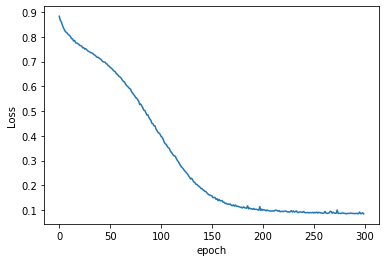

In [36]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

https://stackabuse.com/introduction-to-pytorch-for-classification/

### Prognoza na podstawie modelu

In [37]:
with torch.no_grad():
    y_val_train = model(categorical_train_data, numerical_train_data)
    loss = loss_function( y_val_train, train_outputs)
print(f'Loss train_set: {loss:.8f}')

Loss train_set: 0.08522564


In [38]:
with torch.no_grad():
    y_val = model(categorical_test_data, numerical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.09486609


Ponieważ ustaliliśmy, że nasza warstwa wyjściowa będzie zawierać 2 neurony, każda prognoza będzie zawierać 2 wartości. Przykładowo pierwsze 5 przewidywanych wartości wygląda następująco:

In [39]:
print(y_val[:5])

tensor([[ 2.7729, -2.1325],
        [ 2.8719, -2.2358],
        [ 0.7363, -1.1285],
        [ 2.4189, -2.3633],
        [ 1.9768, -1.9941]])


Celem takich prognoz jest to, że jeśli rzeczywisty wynik wynosi 0, wartość przy indeksie 0 powinna być wyższa niż wartość przy indeksie 1 i odwrotnie. Możemy pobrać indeks największej wartości z listy za pomocą następującego skryptu:

In [40]:
y_val = np.argmax(y_val, axis=1)

Powyższe równanie zwraca wskaźniki wartości maksymalnych wzdłuż osi.

In [41]:
print(y_val[:195])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])


Ponieważ na liście pierwotnie przewidywanych wyników dla pierwszych pięciu rekordów wartości przy zerowych indeksach są większe niż wartości przy pierwszych indeksach, możemy zobaczyć 0 w pierwszych pięciu wierszach przetworzonych danych wyjściowych.

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs, y_val))

[[5689    0]
 [ 123    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5689
           1       0.00      0.00      0.00       123

    accuracy                           0.98      5812
   macro avg       0.49      0.50      0.49      5812
weighted avg       0.96      0.98      0.97      5812

0.9788368891947694


/home/wojciech/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model słabo wykrywa udar. 

### Zapisujemy cały model

In [43]:
torch.save(model,'/home/wojciech/Pulpit/3/byk.pb')

/home/wojciech/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Odtwarzamy cały model

In [44]:
KOT = torch.load('/home/wojciech/Pulpit/3/byk.pb')
KOT.eval()

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(4, 3)
    (2): Embedding(4, 3)
    (3): Embedding(4, 3)
    (4): Embedding(7, 5)
    (5): Embedding(4, 3)
    (6): Embedding(5, 4)
    (7): Embedding(12, 7)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm_num): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=34, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, aff

### Podstawiając inne zmienne niezależne można uzyskać wektor zmiennych wyjściowych

In [45]:
A = categorical_train_data[::50]
A

tensor([[1, 1, 0,  ..., 1, 1, 5],
        [0, 1, 0,  ..., 0, 1, 5],
        [1, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 9],
        [0, 0, 0,  ..., 1, 1, 1],
        [1, 0, 0,  ..., 1, 1, 9]])

In [46]:
B = numerical_train_data[::50]
B

tensor([[ 87.9600,  39.2000,  58.0932],
        [235.8500,  40.1000,  57.0329],
        [ 80.8100,  33.2000,  34.1260],
        ...,
        [139.9900,  26.8000,  20.0493],
        [ 61.3100,  33.1000,  29.0575],
        [ 92.2200,  35.0000,  21.0603]])

In [47]:
y =train_outputs[::50]

In [48]:
y_pred_AB = KOT(A, B)
y_pred_AB[:10]

tensor([[ 1.8608, -1.9731],
        [ 1.5545, -1.8781],
        [ 2.3705, -2.1801],
        [ 1.4825, -1.7660],
        [ 1.9961, -2.0050],
        [ 2.0910, -2.0830],
        [ 2.2859, -2.1231],
        [ 1.9538, -2.0031],
        [ 2.2112, -2.1295],
        [ 2.4439, -2.1890]], grad_fn=<SliceBackward>)

In [49]:
with torch.no_grad():
    y_val_AB = KOT(A,B)
    loss = loss_function( y_val_AB, y)
print(f'Loss train_set: {loss:.8f}')

Loss train_set: 0.10529844


In [50]:
y_val = np.argmax(y_val_AB, axis=1)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y,y_val))
print(classification_report(y,y_val))
print(accuracy_score(y, y_val))

[[453   0]
 [ 12   0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       453
           1       0.00      0.00      0.00        12

    accuracy                           0.97       465
   macro avg       0.49      0.50      0.49       465
weighted avg       0.95      0.97      0.96       465

0.9741935483870968


In [52]:
print('Pomiar czasu wykonania tego zadania:')
print(time.time() - start_time) ## koniec pomiaru czasu

Pomiar czasu wykonania tego zadania:
347.3095963001251


GPU: 352 s
CPU: 347 s